# Model Building and Analysis, 2003 to 2012 Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('hdb-price-with-features-2003to2012.csv').iloc[:, 1:]
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured
0,2012-09-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,85.0,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,2,7.635584,1
1,2012-03-01,BISHAN,4 ROOM,289,BISHAN ST 24,01 TO 05,102.0,Premium Apartment,1998,85.0,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,2,7.635584,1
2,2012-03-01,BISHAN,5 ROOM,289,BISHAN ST 24,11 TO 15,121.0,Premium Apartment,1998,85.0,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,2,7.635584,1
3,2012-02-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,85.0,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,2,7.635584,1
4,2011-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,86.0,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,2,7.635584,1


In [3]:
cpi = pd.read_csv('monthly cpi.csv')
cpi = cpi.set_index('Data Series')
cpi_data = pd.DataFrame(cpi.columns, columns=['month'])
cpi_data['CPI'] = pd.to_numeric(np.array(cpi.loc['All Items']))
cpi_data = cpi_data.iloc[1: , :]
cpi_data['month'] = pd.to_datetime(cpi_data['month'])

cpi_data.head()

,month,CPI
1,2023-01-01,111.397
2,2022-12-01,111.186
3,2022-11-01,110.959
4,2022-10-01,109.893
5,2022-09-01,110.339


In [4]:
cpi_data.dtypes

month    datetime64[ns]
CPI             float64
dtype: object

In [5]:
df['month'] = pd.to_datetime(df['month'])
df = pd.merge(df, cpi_data, how = 'left')
df['adjusted_price'] = (df['resale_price'] / df['CPI']) * 100
df['year'] = pd.DatetimeIndex(df['month']).year
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,CPI,adjusted_price,year
0,2012-09-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,85.0,...,Catholic High School,1,['Catholic High School'],3,2,7.635584,1,97.298,657773.027195,2012
1,2012-03-01,BISHAN,4 ROOM,289,BISHAN ST 24,01 TO 05,102.0,Premium Apartment,1998,85.0,...,Catholic High School,1,['Catholic High School'],3,2,7.635584,1,95.207,630205.762181,2012
2,2012-03-01,BISHAN,5 ROOM,289,BISHAN ST 24,11 TO 15,121.0,Premium Apartment,1998,85.0,...,Catholic High School,1,['Catholic High School'],3,2,7.635584,1,95.207,766750.343987,2012
3,2012-02-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,85.0,...,Catholic High School,1,['Catholic High School'],3,2,7.635584,1,94.491,756685.821930,2012
4,2011-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,100.0,Premium Apartment,1998,86.0,...,Catholic High School,1,['Catholic High School'],3,2,7.635584,1,93.877,637003.738935,2011


In [6]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'latitude', 'longitude',
       'shortest_dist_mrt_name', 'shortest_dist_mrt', 'mrt_count_within_1km',
       'mrt_list_within_1km', 'shortest_dist_mall_name', 'shortest_dist_mall',
       'mall_count_within_1km', 'mall_list_within_1km', 'school_shortest_dist',
       'school_shortest_dist_name', 'good_sch_count_within_1km',
       'good_sch_list_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'CPI', 'adjusted_price', 'year'],
      dtype='object')

In [7]:
data = df.drop(['month','block', 'street_name', 'lease_commence_date',
                'resale_price','address', 'latitude', 'longitude',
                'shortest_dist_mrt_name', 'mrt_list_within_1km',
                'shortest_dist_mall_name','mall_list_within_1km',
                'school_shortest_dist_name', 'good_sch_list_within_1km', 'CPI'],
               axis = 1)
data.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
0,BISHAN,4 ROOM,07 TO 09,100.0,Premium Apartment,85.0,0.754215,1,0.824707,1,0.214393,1,3,2,7.635584,1,657773.027195,2012
1,BISHAN,4 ROOM,01 TO 05,102.0,Premium Apartment,85.0,0.754215,1,0.824707,1,0.214393,1,3,2,7.635584,1,630205.762181,2012
2,BISHAN,5 ROOM,11 TO 15,121.0,Premium Apartment,85.0,0.754215,1,0.824707,1,0.214393,1,3,2,7.635584,1,766750.343987,2012
3,BISHAN,5 ROOM,07 TO 09,121.0,Premium Apartment,85.0,0.754215,1,0.824707,1,0.214393,1,3,2,7.635584,1,756685.821930,2012
4,BISHAN,4 ROOM,07 TO 09,100.0,Premium Apartment,86.0,0.754215,1,0.824707,1,0.214393,1,3,2,7.635584,1,637003.738935,2011


In [8]:
df['storey_range'].value_counts().sort_index()

01 TO 03    57347
01 TO 05     2695
04 TO 06    68951
06 TO 10     2472
07 TO 09    60254
10 TO 12    51454
11 TO 15     1259
13 TO 15    19513
16 TO 18     7523
16 TO 20      265
19 TO 21     3383
21 TO 25       92
22 TO 24     2115
25 TO 27      938
26 TO 30       39
28 TO 30      460
31 TO 33       35
31 TO 35        2
34 TO 36       26
36 TO 40        7
37 TO 39       32
40 TO 42       13
Name: storey_range, dtype: int64

In [9]:
# label encoding for Storey Range
# The higher the storey_range, the higher the label encoding
le = LabelEncoder()
data = data.sort_values(by='storey_range')
data['storey_range'] = le.fit_transform(data['storey_range'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
278874,BUKIT MERAH,3 ROOM,0,72.0,New Generation,76.0,0.688638,1,1.188882,0,0.276903,0,0,0,3.930502,1,174121.087260,2003
182898,HOUGANG,4 ROOM,0,100.0,Model A,93.0,0.189925,1,0.391897,1,0.442774,3,4,1,10.075326,0,383709.545106,2003
182894,HOUGANG,4 ROOM,0,100.0,Model A,92.0,0.189925,1,0.391897,1,0.442774,3,4,1,10.075326,0,398359.542344,2004
58724,SERANGOON,5 ROOM,0,123.0,Improved,85.0,2.982743,0,0.575286,1,0.810757,1,2,1,7.283345,1,447919.427511,2003
182884,HOUGANG,5 ROOM,0,117.0,Improved,90.0,0.189925,1,0.391897,1,0.442774,3,4,1,10.075326,0,464180.721027,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161885,QUEENSTOWN,4 ROOM,21,90.0,Model A,95.0,0.207722,1,0.590811,2,0.199847,0,0,0,4.938780,1,846675.223491,2010
161901,QUEENSTOWN,4 ROOM,21,85.0,Model A,95.0,0.207722,1,0.590811,2,0.199847,0,0,0,4.938780,1,731579.864135,2010
54282,QUEENSTOWN,4 ROOM,21,85.0,Model A,95.0,0.236613,1,1.146641,0,0.142235,0,0,0,5.996707,1,804607.090345,2012
89630,TOA PAYOH,4 ROOM,21,90.0,Model A,97.0,0.253923,2,1.203001,0,0.336099,2,2,1,5.176996,1,742406.472924,2011


In [10]:
data['flat_type'].value_counts()

4 ROOM              106622
3 ROOM               83878
5 ROOM               64450
EXECUTIVE            20781
2 ROOM                2818
1 ROOM                 205
MULTI-GENERATION       121
Name: flat_type, dtype: int64

In [11]:
# remove flat_types with less than 1000 instances
flat_types_counts = data['flat_type'].value_counts()
data = data[~data['flat_type'].isin(flat_types_counts[flat_types_counts < 1000].index)]
data['flat_type'].value_counts()

4 ROOM       106622
3 ROOM        83878
5 ROOM        64450
EXECUTIVE     20781
2 ROOM         2818
Name: flat_type, dtype: int64

 1 Room and Multi-Generation flats are removed.

In [12]:
# label encoding for Flat Type
data = data.sort_values(by='flat_type')
data


,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
78676,ANG MO KIO,2 ROOM,5,45.0,Improved,79.0,1.223882,0,1.093595,0,0.176446,1,2,1,9.741780,1,162966.765046,2006
276272,QUEENSTOWN,2 ROOM,2,46.0,Standard,61.0,0.564398,1,1.301498,0,0.408652,0,0,0,6.178340,1,216726.608170,2008
277374,QUEENSTOWN,2 ROOM,0,43.0,Standard,60.0,0.576045,2,1.214740,0,0.333109,0,0,0,6.049047,1,216966.072352,2010
174201,BUKIT MERAH,2 ROOM,2,44.0,Improved,71.0,1.736306,0,1.579534,0,0.195313,0,0,0,5.019739,1,153984.344925,2006
278036,QUEENSTOWN,2 ROOM,4,46.0,Standard,56.0,0.426263,1,1.210825,0,0.347173,0,0,0,6.204326,1,282903.084892,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169943,BEDOK,EXECUTIVE,7,143.0,Apartment,85.0,0.822479,1,1.538079,0,0.197839,3,3,1,11.300734,1,552637.053989,2007
169942,BEDOK,EXECUTIVE,7,141.0,Apartment,85.0,0.822479,1,1.538079,0,0.197839,3,3,1,11.300734,1,534779.785324,2007
538,GEYLANG,EXECUTIVE,7,146.0,Maisonette,79.0,0.936209,2,1.247203,0,0.565723,3,3,0,5.565481,1,473348.901418,2006
69952,KALLANG/WHAMPOA,EXECUTIVE,4,150.0,Maisonette,74.0,0.829571,1,1.297158,0,0.862132,2,2,2,4.498234,1,629085.253914,2009


In [13]:
data['flat_type'] = le.fit_transform(data['flat_type'])
data

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,good_sch_score,good_sch_score_sap_gep,distance_to_cbd_km,matured,adjusted_price,year
78676,ANG MO KIO,0,5,45.0,Improved,79.0,1.223882,0,1.093595,0,0.176446,1,2,1,9.741780,1,162966.765046,2006
276272,QUEENSTOWN,0,2,46.0,Standard,61.0,0.564398,1,1.301498,0,0.408652,0,0,0,6.178340,1,216726.608170,2008
277374,QUEENSTOWN,0,0,43.0,Standard,60.0,0.576045,2,1.214740,0,0.333109,0,0,0,6.049047,1,216966.072352,2010
174201,BUKIT MERAH,0,2,44.0,Improved,71.0,1.736306,0,1.579534,0,0.195313,0,0,0,5.019739,1,153984.344925,2006
278036,QUEENSTOWN,0,4,46.0,Standard,56.0,0.426263,1,1.210825,0,0.347173,0,0,0,6.204326,1,282903.084892,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169943,BEDOK,4,7,143.0,Apartment,85.0,0.822479,1,1.538079,0,0.197839,3,3,1,11.300734,1,552637.053989,2007
169942,BEDOK,4,7,141.0,Apartment,85.0,0.822479,1,1.538079,0,0.197839,3,3,1,11.300734,1,534779.785324,2007
538,GEYLANG,4,7,146.0,Maisonette,79.0,0.936209,2,1.247203,0,0.565723,3,3,0,5.565481,1,473348.901418,2006
69952,KALLANG/WHAMPOA,4,4,150.0,Maisonette,74.0,0.829571,1,1.297158,0,0.862132,2,2,2,4.498234,1,629085.253914,2009


In [14]:
data['flat_model'].value_counts()

Model A                77418
Improved               76153
New Generation         51445
Premium Apartment      18713
Simplified             16074
Standard               12740
Apartment              11322
Maisonette              7471
Model A2                5775
Adjoined flat            602
Model A-Maisonette       508
Terrace                  243
Premium Maisonette        38
Improved-Maisonette       34
2-room                    13
Name: flat_model, dtype: int64

In [15]:
# Re-categorize flat models into broader categories
replace_values = {'Model A-Maisonette':'Maisonette', 'Improved-Maisonette':'Maisonette',
                 'Premium Maisonette':'Maisonette',}
data = data.replace({'flat_model': replace_values})
data['flat_model'].value_counts()

Model A              77418
Improved             76153
New Generation       51445
Premium Apartment    18713
Simplified           16074
Standard             12740
Apartment            11322
Maisonette            8051
Model A2              5775
Adjoined flat          602
Terrace                243
2-room                  13
Name: flat_model, dtype: int64

In [16]:
# remove flat models with less than 1000 instances
flat_model_counts = data['flat_model'].value_counts()
data = data[~data['flat_model'].isin(flat_model_counts[flat_model_counts < 1000].index)]
data['flat_model'].value_counts()

Model A              77418
Improved             76153
New Generation       51445
Premium Apartment    18713
Simplified           16074
Standard             12740
Apartment            11322
Maisonette            8051
Model A2              5775
Name: flat_model, dtype: int64

In [17]:
data['town'].sort_values().unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [18]:
data['flat_model'].sort_values().unique()

array(['Apartment', 'Improved', 'Maisonette', 'Model A', 'Model A2',
       'New Generation', 'Premium Apartment', 'Simplified', 'Standard'],
      dtype=object)

In [19]:
data = pd.get_dummies(data, columns = ['town','flat_model'],drop_first = True)
data.sort_index(inplace = True)
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'remaining_lease',
       'shortest_dist_mrt', 'mrt_count_within_1km', 'shortest_dist_mall',
       'mall_count_within_1km', 'school_shortest_dist',
       'good_sch_count_within_1km', 'good_sch_score', 'good_sch_score_sap_gep',
       'distance_to_cbd_km', 'matured', 'adjusted_price', 'year', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_Improved', 'flat_model_Maisonette', 'flat_model_Model A',
       'flat_model_Model A2', 'flat_model_New Generation',
   

In order to account for multicollinearity, we drop one of the dummy variables.

For the town dummies, Ang Mo Kio is dropped. For the flat_model dummies, Apartment is dropped.

### Check for Multicolinearity and VIF

In [20]:
data.dtypes

flat_type                         int32
storey_range                      int32
floor_area_sqm                  float64
remaining_lease                 float64
shortest_dist_mrt               float64
mrt_count_within_1km              int64
shortest_dist_mall              float64
mall_count_within_1km             int64
school_shortest_dist            float64
good_sch_count_within_1km         int64
good_sch_score                    int64
good_sch_score_sap_gep            int64
distance_to_cbd_km              float64
matured                           int64
adjusted_price                  float64
year                              int64
town_BEDOK                        uint8
town_BISHAN                       uint8
town_BUKIT BATOK                  uint8
town_BUKIT MERAH                  uint8
town_BUKIT PANJANG                uint8
town_BUKIT TIMAH                  uint8
town_CENTRAL AREA                 uint8
town_CHOA CHU KANG                uint8
town_CLEMENTI                     uint8


In [21]:
data['flat_type'] = data['flat_type'].astype("int64")
data['storey_range'] = data['storey_range'].astype("int64")

C:\Users\tammy\AppData\Local\Temp\ipykernel_19080\1764189709.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


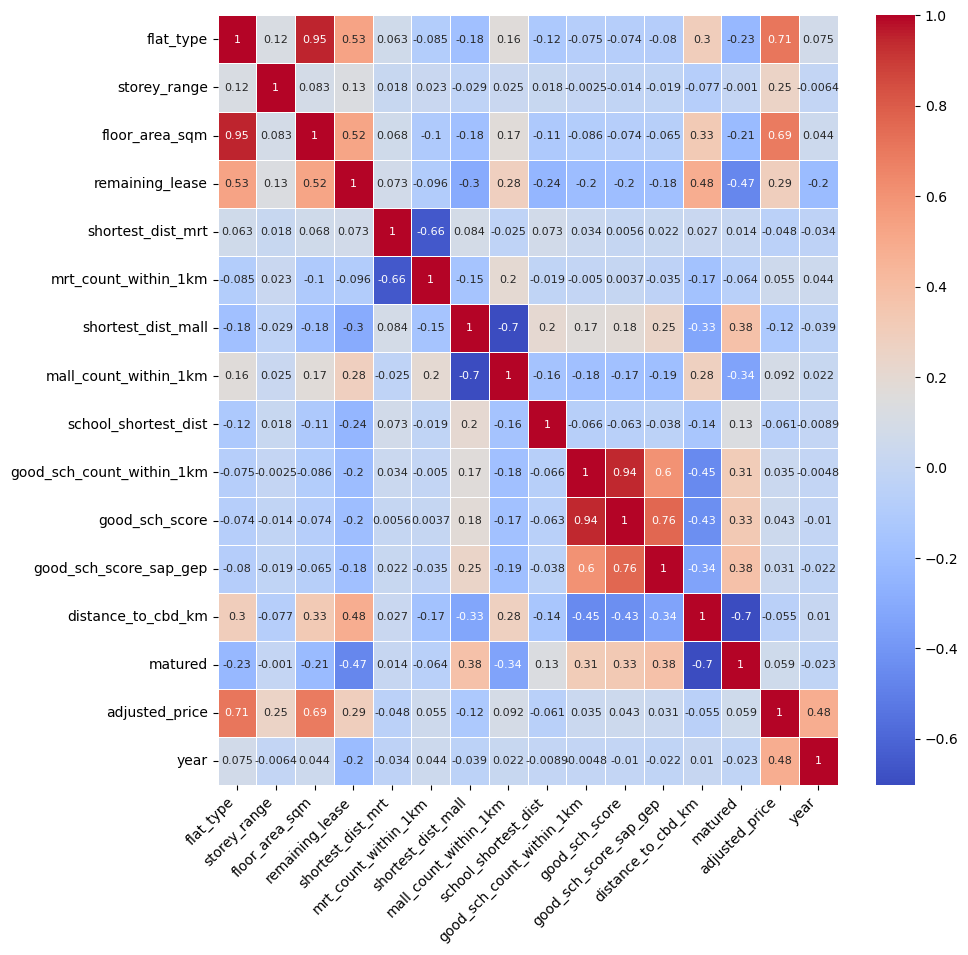

In [22]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(data.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
      cmap = 'coolwarm', linewidth=0.5, annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right')
fig.show()


High correlation (>0.6) between:

- flat_type and floor_area_sqm (0.95)
- shortest_dist_mrt and mrt_count_within_1km (-0.66)
- mall_count_within_1km and shortest_dist_mall (-0.7)
- good_sch_count_within_1km and good_sch_score (0.94)
- good_sch_score_sap_gep and good_sch_count_within_1km (0.6)
- good_sch_score_sap_gep and good_sch_score (0.76)
- distance_to_cbd_km and matured (-0.7)



Apart from correlation, we also check the VIF scores. Generally, if the largest VIF score is greater than 10 (Bowerman & O'Connell, 1990), and a tolerance below 0.1 (Menard, 1995) indicates a likely issue of the regression being biased.

In [23]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

vif_df = calc_vif(data.drop('adjusted_price',axis=1).select_dtypes(include=['int64','float64']))
vif_df

,variables,VIF,tolerance,meanVIF
0,flat_type,67.222095,0.014876,45.154198
1,storey_range,2.840676,0.352029,45.154198
2,floor_area_sqm,181.577842,0.005507,45.154198
3,remaining_lease,130.201243,0.007680,45.154198
4,shortest_dist_mrt,6.552378,0.152616,45.154198
5,mrt_count_within_1km,4.880875,0.204881,45.154198
6,shortest_dist_mall,7.954534,0.125714,45.154198
7,mall_count_within_1km,4.298856,0.232620,45.154198
8,school_shortest_dist,4.174968,0.239523,45.154198
9,good_sch_count_within_1km,17.680339,0.056560,45.154198


between flat_type and floor_area_sqm, we will drop flat_type as floor_area_sqm could have more potential for feature explanation as it is a continuous variable, while flat_type has been label encoded.

For the mrt, mall, sch features, we will choose to drop the features that measure the count within 1km first, for reasons being the shortest distance features being continuous.

Between distance to cbd and matured features, we will drop matured as distance to cbd is a continous variable as well.

Between good_sch_score_sap_gep and good_sch_score, we will just drop good_sch_score_sap_gep for the time being. Depending on the results of the good_sch_score feature results, we will decide if there is reason to run the models again but with good_sch_score_sap_gep instead.

year variable is dropped as well, as we have already accounted for resale price inflation using CPI values. This should account for majority of the impact that year has on resale prices, due to the fact that generally why prices increases over time is due to inflation. It is also dropped for model simplicity.


In [24]:
dropped_features = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score_sap_gep',
                    'year']

calc_vif(data.drop(dropped_features,axis=1).
         drop('adjusted_price', axis = 1).
         select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,storey_range,2.809879,0.355887,11.753926
1,floor_area_sqm,22.111310,0.045226,11.753926
2,remaining_lease,42.609475,0.023469,11.753926
3,shortest_dist_mrt,3.479367,0.287409,11.753926
4,shortest_dist_mall,3.896967,0.256610,11.753926
5,school_shortest_dist,3.666805,0.272717,11.753926
6,good_sch_score,1.670378,0.598667,11.753926
7,distance_to_cbd_km,13.787231,0.072531,11.753926


We observe that remaining_lease and floor_area_sqm still has a very high VIF score, but we shall still keep these features as we feel they are important explainators of hdb resale price.

### Performance Measure

In [25]:
def model_performance(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('R^2 score =', r2)
    print('MAE:', mae)
    print('RMSE', rmse)
    
    
    return(r2, mae, rmse)
    

### Train Test Split

In [26]:
df_1 = data.drop(columns = dropped_features)

# Split target variable from dataset
y= df_1['adjusted_price']
X = df_1.drop(columns='adjusted_price')


In [27]:
X

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
0,4,100.0,85.0,0.754215,0.824707,0.214393,3,7.635584,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,102.0,85.0,0.754215,0.824707,0.214393,3,7.635584,0,1,...,0,0,0,0,0,0,0,1,0,0
2,6,121.0,85.0,0.754215,0.824707,0.214393,3,7.635584,0,1,...,0,0,0,0,0,0,0,1,0,0
3,4,121.0,85.0,0.754215,0.824707,0.214393,3,7.635584,0,1,...,0,0,0,0,0,0,0,1,0,0
4,4,100.0,86.0,0.754215,0.824707,0.214393,3,7.635584,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278870,5,67.0,74.0,0.888593,1.199259,0.232608,0,10.517164,1,0,...,0,0,0,0,0,0,1,0,0,0
278871,2,43.0,67.0,0.615231,0.602241,0.770173,0,6.106561,0,0,...,0,0,0,0,0,0,0,0,0,1
278872,4,41.0,67.0,0.615231,0.602241,0.770173,0,6.106561,0,0,...,0,0,0,0,0,0,0,0,0,1
278873,2,40.0,67.0,0.615231,0.602241,0.770173,0,6.106561,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [29]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

222152 55539
222152 55539


### Feature Scaling

In [30]:
# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X_train_continuous = X_train[continuous_features]
X_train_continuous = scaler.fit_transform(X_train_continuous)

X_test_continuous = X_test[continuous_features]
X_test_continuous = scaler.transform(X_test_continuous)

# Replace original continuous features with scaled ones in X

X_train[continuous_features] = X_train_continuous
X_test[continuous_features] = X_test_continuous

In [31]:
X_train

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
245354,4,0.579570,1.103455,-1.200406,-1.090492,-0.560221,1,1.005298,0,0,...,0,0,0,0,1,0,0,0,0,0
78833,2,-1.094434,-0.756350,0.395314,0.063775,-0.063839,2,-0.552596,0,0,...,0,0,0,0,0,0,1,0,0,0
90233,5,0.141141,1.206778,-0.229171,-1.297316,0.005879,0,1.454509,0,0,...,1,0,0,0,1,0,0,0,0,0
7807,13,-0.257432,1.310100,1.390512,-0.547523,-0.815531,0,0.617630,0,0,...,0,0,0,0,0,0,0,1,0,0
18270,0,-1.174149,-1.169641,-0.403211,2.786497,0.263445,0,-0.591348,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213775,7,0.738999,0.896810,-0.156975,-1.302809,-0.837744,0,0.043785,0,0,...,0,0,1,0,0,0,0,0,0,0
66021,4,-1.134291,-0.859673,0.279599,1.560288,2.802541,0,-0.466463,0,0,...,0,0,0,0,0,0,1,0,0,0
254757,4,0.300570,0.586843,0.527839,0.654508,-0.221206,0,0.383628,0,0,...,0,0,0,0,1,0,0,0,0,0
211605,2,1.057857,0.896810,0.160949,-1.217243,-0.455924,0,1.443391,0,0,...,1,0,1,0,0,0,0,0,0,0


In [32]:
X_test

,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,shortest_dist_mall,school_shortest_dist,good_sch_score,distance_to_cbd_km,town_BEDOK,town_BISHAN,...,town_WOODLANDS,town_YISHUN,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
104731,4,0.539713,1.620068,1.797083,-0.873372,-0.430706,1,0.425974,0,0,...,0,0,0,0,0,0,0,1,0,0
183147,0,1.934717,0.070230,-0.020845,-0.094241,0.206288,0,0.691295,0,0,...,0,0,0,0,0,0,0,0,0,0
120915,12,-0.257432,1.000133,-0.918339,-1.214305,1.278439,0,-0.662694,0,0,...,0,0,0,0,1,0,0,0,0,0
253632,4,0.938286,1.310100,0.751060,0.103502,-0.816332,2,-0.415117,0,0,...,0,0,1,0,0,0,0,0,0,0
114257,2,2.054289,-0.756350,0.139434,1.257937,1.455217,2,-1.687105,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228674,0,-0.456718,1.413423,1.560383,-0.595769,-0.838990,0,0.595293,0,0,...,0,0,0,0,0,1,0,0,0,0
135726,2,0.938286,-0.136415,-0.595970,-0.117310,0.806369,0,0.662519,0,0,...,0,1,1,0,0,0,0,0,0,0
86226,0,-1.931436,-1.892898,-1.067020,-1.094257,0.574269,0,-2.109554,0,0,...,0,0,0,0,0,0,0,0,0,1
86583,4,-0.257432,1.516745,-0.481182,0.639517,-0.899513,0,-2.225627,0,0,...,0,0,0,0,1,0,0,0,0,0


## Model Building

We have shortlisted the following models to understand the drivers of HDB resale prices:
1. Linear Regression
2. Random Forest (bootstrap method)
3. XGBoost (boosting method)

Linear regression is shortlisted as it provides a useful way to interpret the respective impacts that each feature has on the hdb resale price. We will be able to infer directionality of the impacts as well.

We want to also compare the performances of ensemble methods, which are non-parametric in nature. Specifically, we shortlisted one bagging (bootstrap aggregating) method, which will be Random Forest, and one boosting method, which will be XGBoost. From this, we will compare the performances between the models and investigate feature importance.

#### 1. Linear Regression

In [33]:
lr = LinearRegression()
lin_reg_r2, lin_reg_mae, lin_reg_rmse = model_performance(lr, X_train, X_test, y_train, y_test)

R^2 score = 0.6461261477139044
MAE: 60109.57405705271
RMSE 74270.29053470619


Let's plot the coefficients and observe their respective impacts on hdb resale price

In [34]:
lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
lr_importance.sort_values(by = 'Coeff', ascending = False)

,Features,Coeff
22,town_MARINE PARADE,126876.407148
13,town_BUKIT TIMAH,120095.627655
1,floor_area_sqm,98971.176046
11,town_BUKIT MERAH,66524.690691
24,town_PUNGGOL,53854.753151
9,town_BISHAN,43704.049960
25,town_QUEENSTOWN,42162.323626
16,town_CLEMENTI,36141.717729
38,flat_model_Premium Apartment,35888.100322
30,town_TOA PAYOH,27740.880953


Let's also plot the OLS regression results, to look at the significance of the features.

In [35]:
X_constant = sm.add_constant(X_train)
lr_ols = sm.OLS(y_train,X_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     9869.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:23:49   Log-Likelihood:            -2.8079e+06
No. Observations:              222152   AIC:                         5.616e+06
Df Residuals:                  222110   BIC:                         5.616e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [36]:
lr_importance['Coeff_ABS'] = np.abs(lr_importance['Coeff'])
lr_importance = lr_importance.sort_values('Coeff_ABS', ascending=False).reset_index(drop= True)
lr_importance['color'] = lr_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_importance

,Features,Coeff,Coeff_ABS,color
0,town_MARINE PARADE,126876.407148,126876.407148,#66ff8c
1,town_BUKIT TIMAH,120095.627655,120095.627655,#66ff8c
2,floor_area_sqm,98971.176046,98971.176046,#66ff8c
3,town_CHOA CHU KANG,-75293.732945,75293.732945,#ff8c66
4,town_WOODLANDS,-73151.032664,73151.032664,#ff8c66
5,town_BUKIT MERAH,66524.690691,66524.690691,#66ff8c
6,town_PUNGGOL,53854.753151,53854.753151,#66ff8c
7,town_YISHUN,-53422.063284,53422.063284,#ff8c66
8,town_JURONG WEST,-48470.417279,48470.417279,#ff8c66
9,town_SEMBAWANG,-46149.070319,46149.070319,#ff8c66


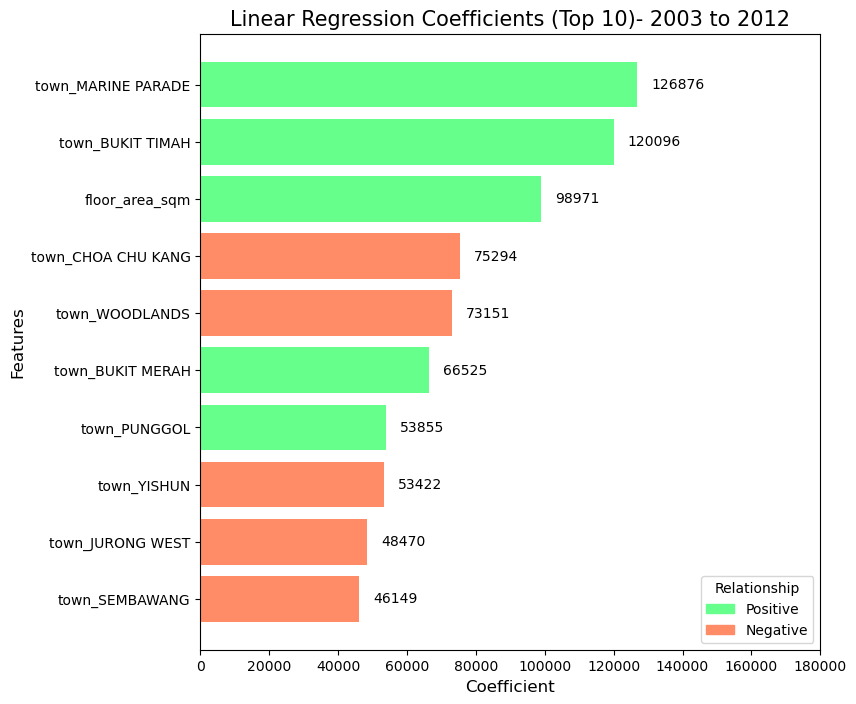

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
lr_importance_graph = lr_importance.head(10)
graph = ax.barh(lr_importance_graph['Features'], lr_importance_graph['Coeff_ABS'],
                color=lr_importance_graph['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Coefficients (Top 10)- 2003 to 2012', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=180000) 
ax.invert_yaxis()

plt.show()

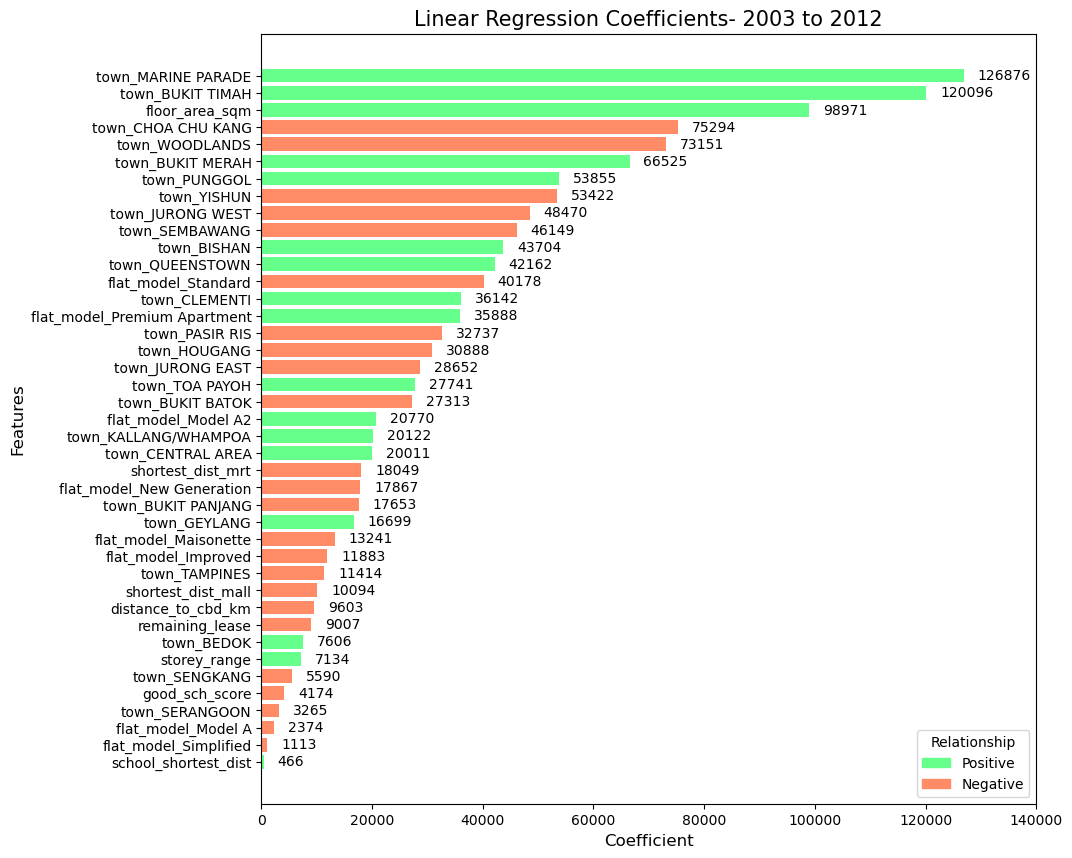

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr_importance['Features'], lr_importance['Coeff_ABS'],
                color=lr_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Coefficients- 2003 to 2012', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=140000) 
ax.invert_yaxis()

plt.show()

#### 2. Random Forest 

Computing the default parameter model

In [39]:
rf = RandomForestRegressor(random_state = 100)
rf_r2, rf_mae, rf_rmse = model_performance(rf, X_train, X_test, y_train, y_test)

R^2 score = 0.9532131990386173
MAE: 19571.807330705913
RMSE 27005.521083441497


Training the default random forest model takes about 6-7 minutes.

In [40]:
rf_importance = pd.DataFrame(list(zip(rf.feature_names_in_, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance = rf_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_importance

,Features,Coeff
0,floor_area_sqm,0.543578
1,distance_to_cbd_km,0.139980
2,remaining_lease,0.131913
3,shortest_dist_mrt,0.042750
4,shortest_dist_mall,0.027604
5,storey_range,0.019700
6,school_shortest_dist,0.019389
7,flat_model_New Generation,0.008254
8,flat_model_Premium Apartment,0.007595
9,flat_model_Model A,0.007237


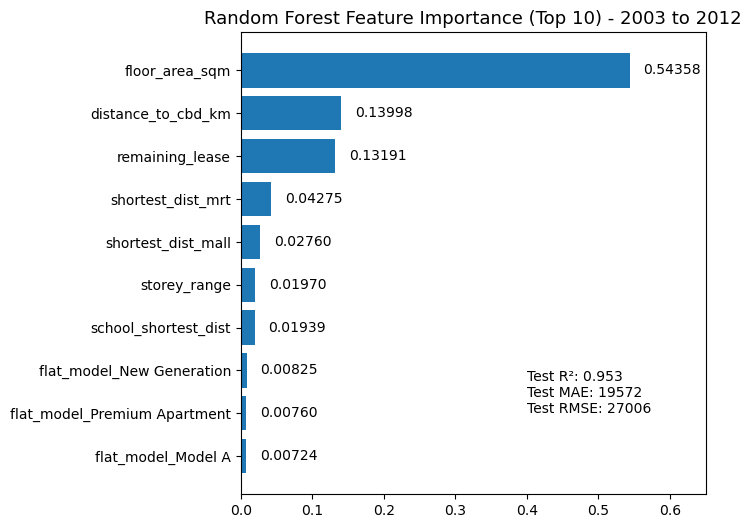

In [41]:
fig, ax = plt.subplots(figsize=(6,6))
rf_importance_graph = rf_importance.head(10)
graph = ax.barh(rf_importance_graph['Features'], rf_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance (Top 10) - 2003 to 2012', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_r2,3)) + '\nTest MAE: ' + str(round(rf_mae))+
             '\nTest RMSE: ' + str(round(rf_rmse))),
             xy=(0.4,8), fontsize = 10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### Hyperparameter tuning using RandomizedSearchCV

In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf1 = RandomForestRegressor(random_state = 100)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, random_state=100)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.7min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.6min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 4.5min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=28.0min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=28.6min
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=29.8min
{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110}


In [33]:
y_pred = rf_random.predict(X_test)

rf_random_r2 = r2_score(y_test, y_pred)
rf_random_mae = mean_absolute_error(y_test, y_pred)
rf_random_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R^2 score =', rf_random_r2)
print('MAE:', rf_random_mae)
print('RMSE', rf_random_rmse)
    

R^2 score = 0.952291090793517
MAE: 19661.007522602955
RMSE 27270.344824438842


In [34]:
rf_random_importance = pd.DataFrame(list(zip(rf_random.feature_names_in_, rf_random.best_estimator_.feature_importances_)),
                                    columns =['Features', 'Coeff'])
rf_random_importance = rf_random_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_random_importance

,Features,Coeff
0,floor_area_sqm,0.553803
1,distance_to_cbd_km,0.140978
2,remaining_lease,0.130332
3,shortest_dist_mrt,0.041411
4,shortest_dist_mall,0.025633
5,school_shortest_dist,0.017315
6,storey_range,0.015413
7,flat_model_New Generation,0.008462
8,flat_model_Premium Apartment,0.007826
9,flat_model_Model A,0.007289


Plotting feature importance for Random Forest with Cross Validation

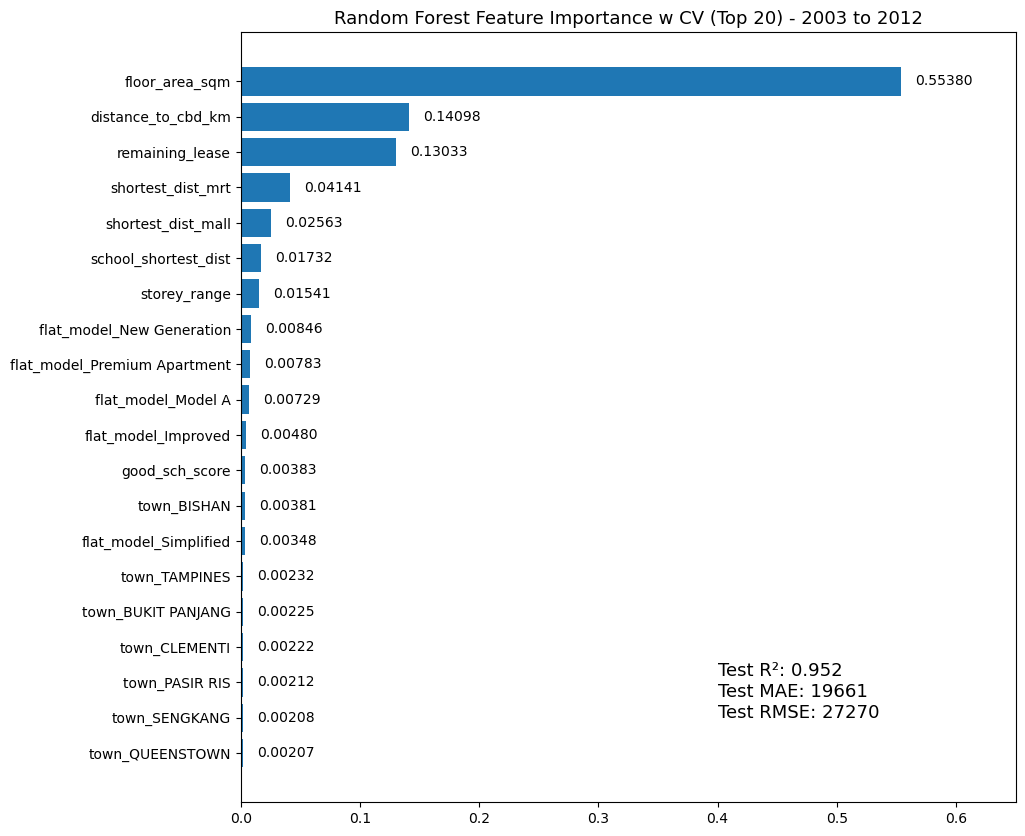

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
rf_random_importance_graph = rf_random_importance.head(20)
graph = ax.barh(rf_random_importance_graph['Features'], rf_random_importance_graph['Coeff'])
plt.title('Random Forest Feature Importance w CV (Top 20) - 2003 to 2012', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(rf_random_r2,3)) + '\nTest MAE: ' + str(round(rf_random_mae))+
             '\nTest RMSE: ' + str(round(rf_random_rmse))),
             xy=(0.4,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### Out-of-Bag Validation for Random Forest

In [50]:
oob_model = RandomForestRegressor(oob_score=True, random_state = 100)
oob_r2, oob_mae, oob_rmse = model_performance(oob_model, X_train, X_test, y_train, y_test)

R^2 score = 0.9532131990386173
MAE: 19571.807330705913
RMSE 27005.521083441497


In [51]:
oob_model.oob_score_

0.9521315242040808

In [52]:
oob_importance = pd.DataFrame(list(zip(oob_model.feature_names_in_, oob_model.feature_importances_)), columns =['Features', 'Coeff'])
oob_importance = oob_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
oob_importance

,Features,Coeff
0,floor_area_sqm,0.543578
1,distance_to_cbd_km,0.139980
2,remaining_lease,0.131913
3,shortest_dist_mrt,0.042750
4,shortest_dist_mall,0.027604
5,storey_range,0.019700
6,school_shortest_dist,0.019389
7,flat_model_New Generation,0.008254
8,flat_model_Premium Apartment,0.007595
9,flat_model_Model A,0.007237


Out of Bag Validation Feature Importance

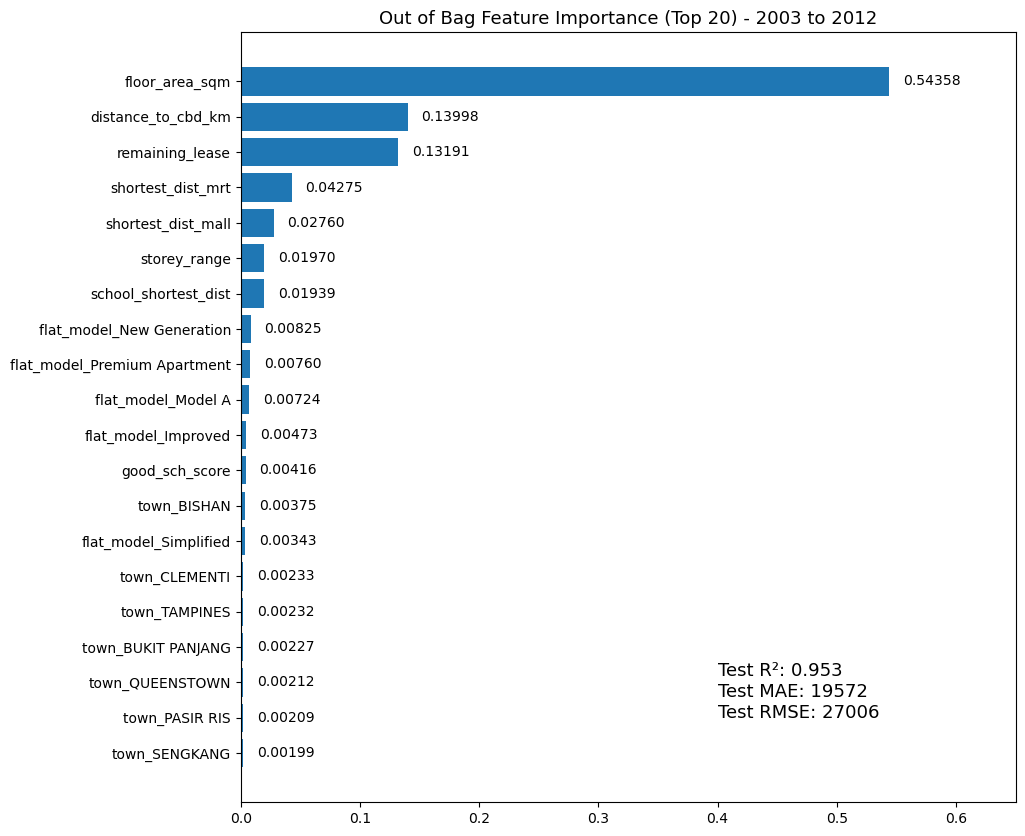

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
oob_importance_graph = oob_importance.head(20)
graph = ax.barh(oob_importance_graph['Features'], oob_importance_graph['Coeff'])
plt.title('Out of Bag Feature Importance (Top 20) - 2003 to 2012', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(oob_r2,3)) + '\nTest MAE: ' + str(round(oob_mae))+
             '\nTest RMSE: ' + str(round(oob_rmse))),
             xy=(0.4,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.65) 
ax.invert_yaxis()


plt.show()

#### 3. XGBoost Default Parameter Model

In [54]:
xgb = XGBRegressor(random_state = 100)
xgb_r2, xgb_mae, xgb_rmse = model_performance(xgb, X_train, X_test, y_train, y_test)

R^2 score = 0.9086696167161652
MAE: 28462.47945286815
RMSE 37731.018278004325


In [55]:
xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance = xgb_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
xgb_importance

,Features,Coeff
0,floor_area_sqm,0.189148
1,flat_model_New Generation,0.060110
2,flat_model_Model A,0.053195
3,distance_to_cbd_km,0.047156
4,flat_model_Premium Apartment,0.044207
5,town_MARINE PARADE,0.044034
6,flat_model_Simplified,0.039702
7,town_PASIR RIS,0.036354
8,town_BUKIT TIMAH,0.032351
9,town_PUNGGOL,0.029045


XGBoost Feature Importance

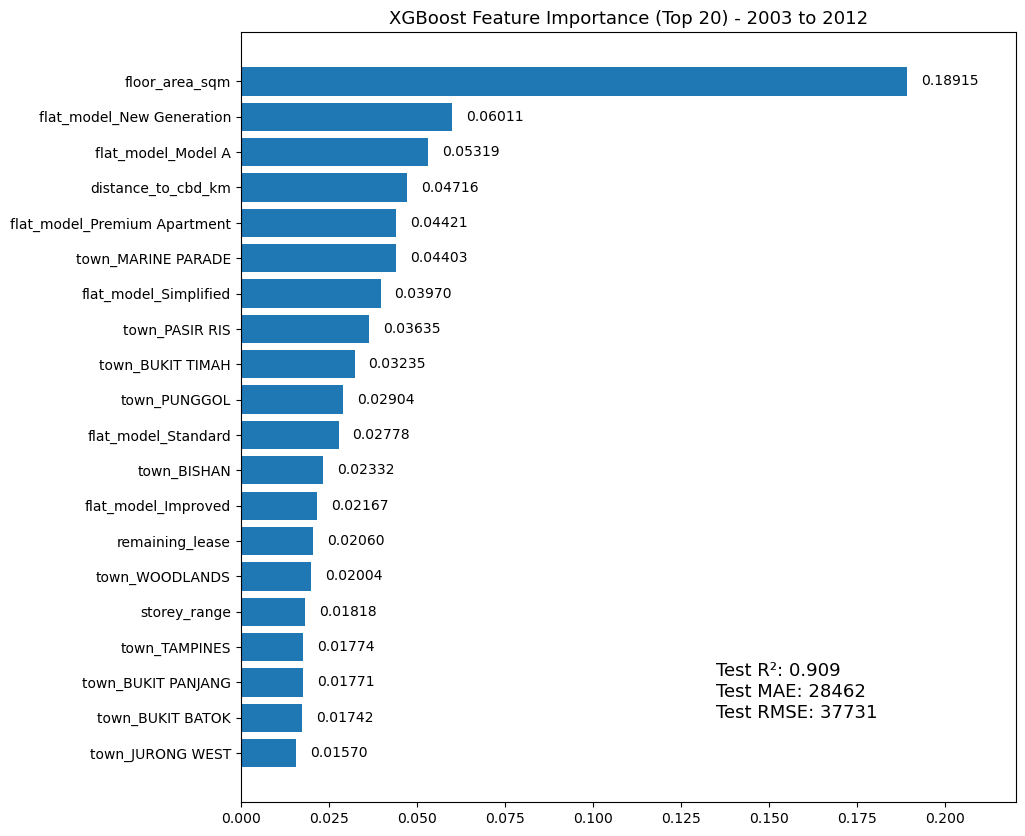

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
xgb_importance_graph = xgb_importance.head(20)
graph = ax.barh(xgb_importance_graph['Features'], xgb_importance_graph['Coeff'])
plt.title('XGBoost Feature Importance (Top 20) - 2003 to 2012', size = 13)
plt.annotate(('Test R\u00b2: ' + str(round(xgb_r2,3)) + '\nTest MAE: ' + str(round(xgb_mae))+
             '\nTest RMSE: ' + str(round(xgb_rmse))),
             xy=(0.135,18), fontsize = 13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.22) 
ax.invert_yaxis()


plt.show()

## Other Analysis

#### swap good_sch_score with good_sch_score_SAP_GEP

In [57]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','flat_type','good_sch_score',
                    'year']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

In [58]:
lr2 = LinearRegression()
lin_reg_2_r2, lin_reg_2_mae, lin_reg_2_rmse = model_performance(lr2, X2_train, X2_test, y2_train, y2_test)

R^2 score = 0.6455208149182721
MAE: 60155.783564226986
RMSE 74333.7863715232


In [59]:
lr_2_importance = pd.DataFrame(list(zip(lr2.feature_names_in_, lr2.coef_)), columns =['Features', 'Coeff'])
lr_2_importance = lr_2_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
lr_2_importance

,Features,Coeff
0,town_MARINE PARADE,120466.709437
1,town_BUKIT TIMAH,114807.796926
2,floor_area_sqm,98846.722196
3,town_BUKIT MERAH,67458.923281
4,town_PUNGGOL,50561.002207
5,town_QUEENSTOWN,43494.780314
6,town_BISHAN,36662.174029
7,town_CLEMENTI,35813.045317
8,flat_model_Premium Apartment,35521.887394
9,town_TOA PAYOH,25297.335822


In [60]:
X2_constant = sm.add_constant(X2_train)
lr_ols = sm.OLS(y2_train,X2_constant).fit()
print(lr_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         adjusted_price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     9849.
Date:                Wed, 05 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:44:40   Log-Likelihood:            -2.8080e+06
No. Observations:              222152   AIC:                         5.616e+06
Df Residuals:                  222110   BIC:                         5.617e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [61]:
lr_2_importance['Coeff_ABS'] = np.abs(lr_2_importance['Coeff'])
lr_2_importance = lr_2_importance.sort_values('Coeff_ABS', ascending = False).reset_index(drop= True)
lr_2_importance['color'] = lr_2_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr_2_importance

,Features,Coeff,Coeff_ABS,color
0,town_MARINE PARADE,120466.709437,120466.709437,#66ff8c
1,town_BUKIT TIMAH,114807.796926,114807.796926,#66ff8c
2,floor_area_sqm,98846.722196,98846.722196,#66ff8c
3,town_CHOA CHU KANG,-75298.793588,75298.793588,#ff8c66
4,town_WOODLANDS,-71988.274878,71988.274878,#ff8c66
5,town_BUKIT MERAH,67458.923281,67458.923281,#66ff8c
6,town_YISHUN,-51862.030242,51862.030242,#ff8c66
7,town_PUNGGOL,50561.002207,50561.002207,#66ff8c
8,town_JURONG WEST,-47418.417981,47418.417981,#ff8c66
9,town_SEMBAWANG,-44905.523607,44905.523607,#ff8c66


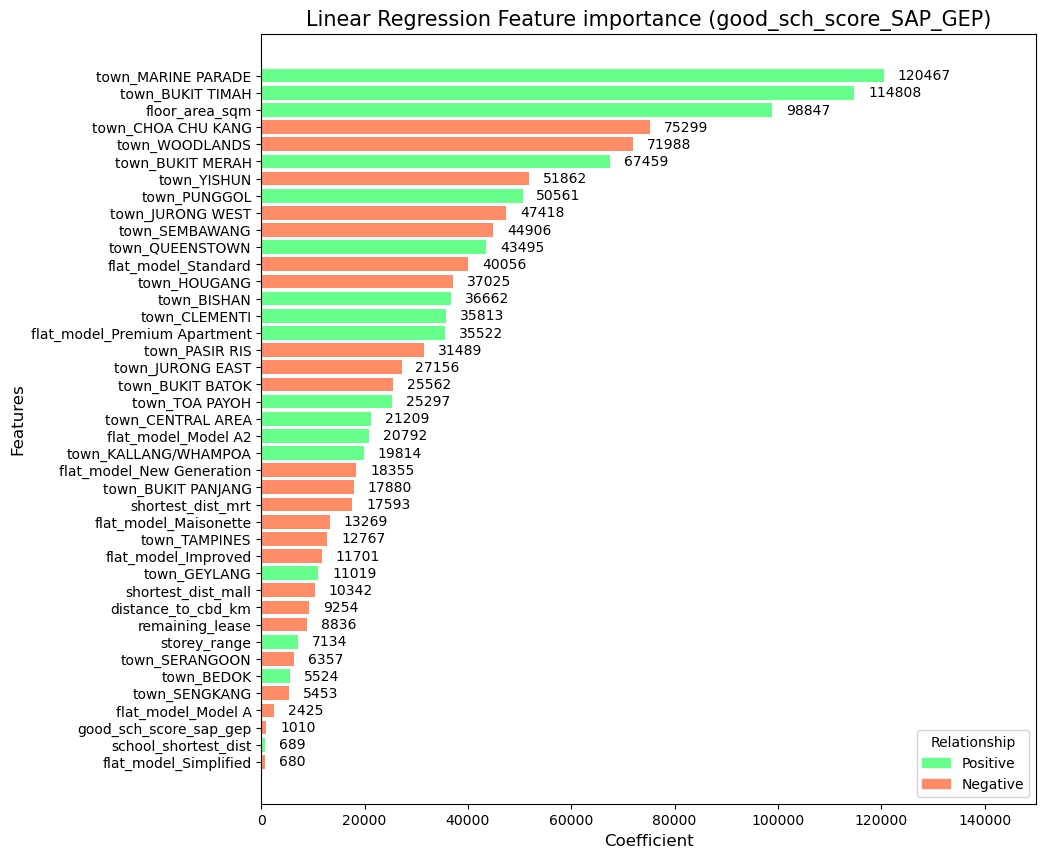

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr_2_importance['Features'], lr_2_importance['Coeff_ABS'],
                color=lr_2_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance (good_sch_score_SAP_GEP)', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=150000) 
ax.invert_yaxis()

plt.show()

We observe a positive coefficient for good_sch_score_sap_gep, which makes sense intuitively, as being near a good school would be associated with higher hdb resale prices.

Running a default parameter Random Forest Model.

In [63]:
rf_2 = RandomForestRegressor(random_state = 100)
rf_2_r2, rf_2_mae, rf_2_rmse = model_performance(rf_2, X2_train, X2_test, y2_train, y2_test)

rf_2_importance = pd.DataFrame(list(zip(rf_2.feature_names_in_, rf_2.feature_importances_)), columns =['Features', 'Coeff'])
rf_2_importance = rf_2_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_2_importance

R^2 score = 0.9532320753093104
MAE: 19568.4669913112
RMSE 27000.07280590949


,Features,Coeff
0,floor_area_sqm,0.543641
1,distance_to_cbd_km,0.140306
2,remaining_lease,0.132054
3,shortest_dist_mrt,0.043074
4,shortest_dist_mall,0.027767
5,storey_range,0.019714
6,school_shortest_dist,0.019561
7,flat_model_New Generation,0.008246
8,flat_model_Premium Apartment,0.007602
9,flat_model_Model A,0.007289


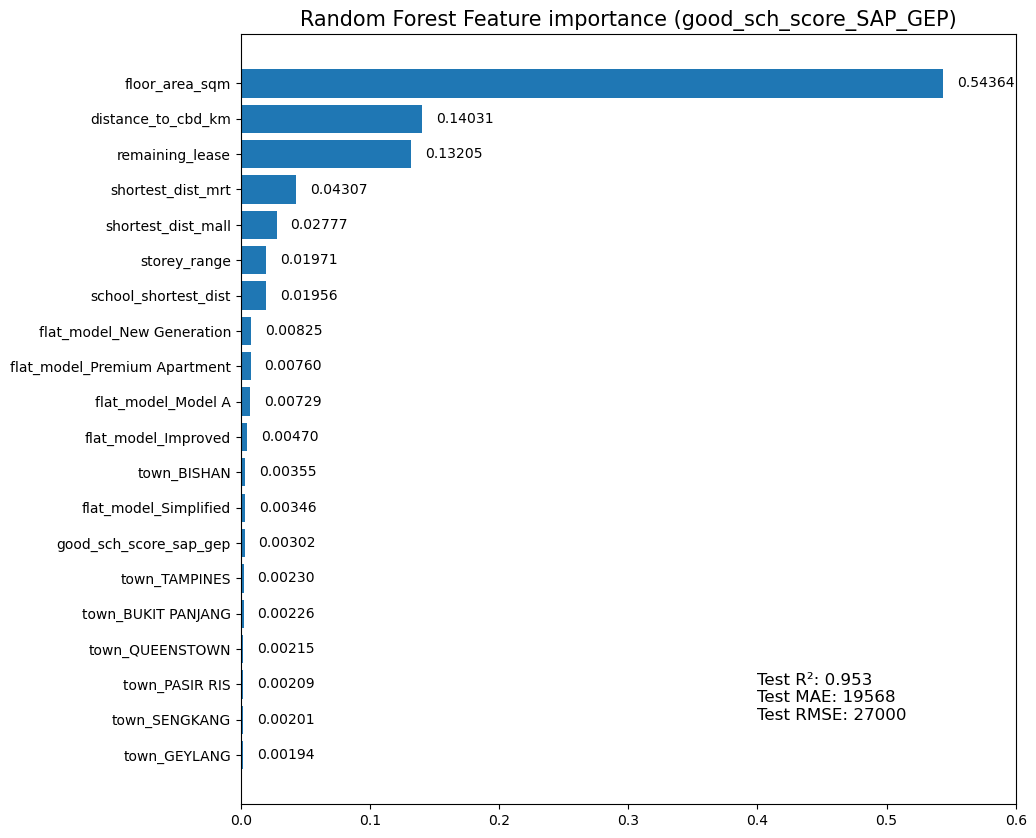

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
rf_2_importance_graph = rf_2_importance.head(20)
graph = ax.barh(rf_2_importance_graph['Features'], rf_2_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (good_sch_score_SAP_GEP)', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_2_r2,3)) + '\nTest MAE: ' + str(round(rf_2_mae))+
             '\nTest RMSE: ' + str(round(rf_2_rmse))),
             xy=(0.4,18), fontsize = 12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.6) 
ax.invert_yaxis()


plt.show()

We observe no significant differ in feature importance from changing good_sch_score to good_sch_score_sap_gep.

#### What if we remove floor_area_sqm, distance_to_cbd_km, and remaining_lease from the feature list?

In [44]:
dropped_features_2 = ['mrt_count_within_1km','mall_count_within_1km',
                    'matured','good_sch_count_within_1km','floor_area_sqm','flat_type',
                    'good_sch_score', 'year', 'distance_to_cbd_km', 'remaining_lease']

df_2 = data.drop(columns = dropped_features_2)

# Split target variable from dataset
y_2= df_2['adjusted_price']
X_2 = df_2.drop(columns='adjusted_price')

X2_train,X2_test,y2_train,y2_test=train_test_split(X_2,y_2,test_size=0.2,random_state=100)

# Scale dataset
continuous_features = ['shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist']

scaler = StandardScaler()
X2_train_continuous = X2_train[continuous_features]
X2_train_continuous = scaler.fit_transform(X2_train_continuous)

X2_test_continuous = X2_test[continuous_features]
X2_test_continuous = scaler.transform(X2_test_continuous)

# Replace original continuous features with scaled ones in X

X2_train[continuous_features] = X2_train_continuous
X2_test[continuous_features] = X2_test_continuous

Running Linear Regression

In [45]:
lr3 = LinearRegression()
lin_reg_3_r2, lin_reg_3_mae, lin_reg_3_rmse = model_performance(lr3, X2_train, X2_test, y2_train, y2_test)

lr3_importance = pd.DataFrame(list(zip(lr3.feature_names_in_, lr3.coef_)), columns =['Features', 'Coeff'])
lr3_importance.sort_values(by = 'Coeff', ascending = False)

R^2 score = 0.3931351762631028
MAE: 75682.32528180101
RMSE 97260.58295827177


,Features,Coeff
10,town_BUKIT TIMAH,123054.715882
19,town_MARINE PARADE,83749.999357
6,town_BISHAN,72050.074978
21,town_PUNGGOL,49556.055646
8,town_BUKIT MERAH,45512.119035
13,town_CLEMENTI,35018.511660
31,flat_model_Maisonette,12711.560094
20,town_PASIR RIS,11930.411888
0,storey_range,9311.045113
25,town_SERANGOON,6973.884419


In [46]:
lr3_importance['Coeff_ABS'] = np.abs(lr3_importance['Coeff'])
lr3_importance = lr3_importance.sort_values('Coeff_ABS', ascending = False).reset_index(drop= True)
lr3_importance['color'] = lr3_importance['Coeff'].apply(lambda x: '#66ff8c' if x>0 else '#ff8c66')
lr3_importance

,Features,Coeff,Coeff_ABS,color
0,flat_model_New Generation,-253633.906883,253633.906883,#ff8c66
1,flat_model_Simplified,-242317.136340,242317.136340,#ff8c66
2,flat_model_Standard,-229862.368189,229862.368189,#ff8c66
3,flat_model_Model A2,-200020.479857,200020.479857,#ff8c66
4,flat_model_Model A,-174844.588608,174844.588608,#ff8c66
5,flat_model_Improved,-160150.060657,160150.060657,#ff8c66
6,town_BUKIT TIMAH,123054.715882,123054.715882,#66ff8c
7,flat_model_Premium Apartment,-110682.799770,110682.799770,#ff8c66
8,town_MARINE PARADE,83749.999357,83749.999357,#66ff8c
9,town_BISHAN,72050.074978,72050.074978,#66ff8c


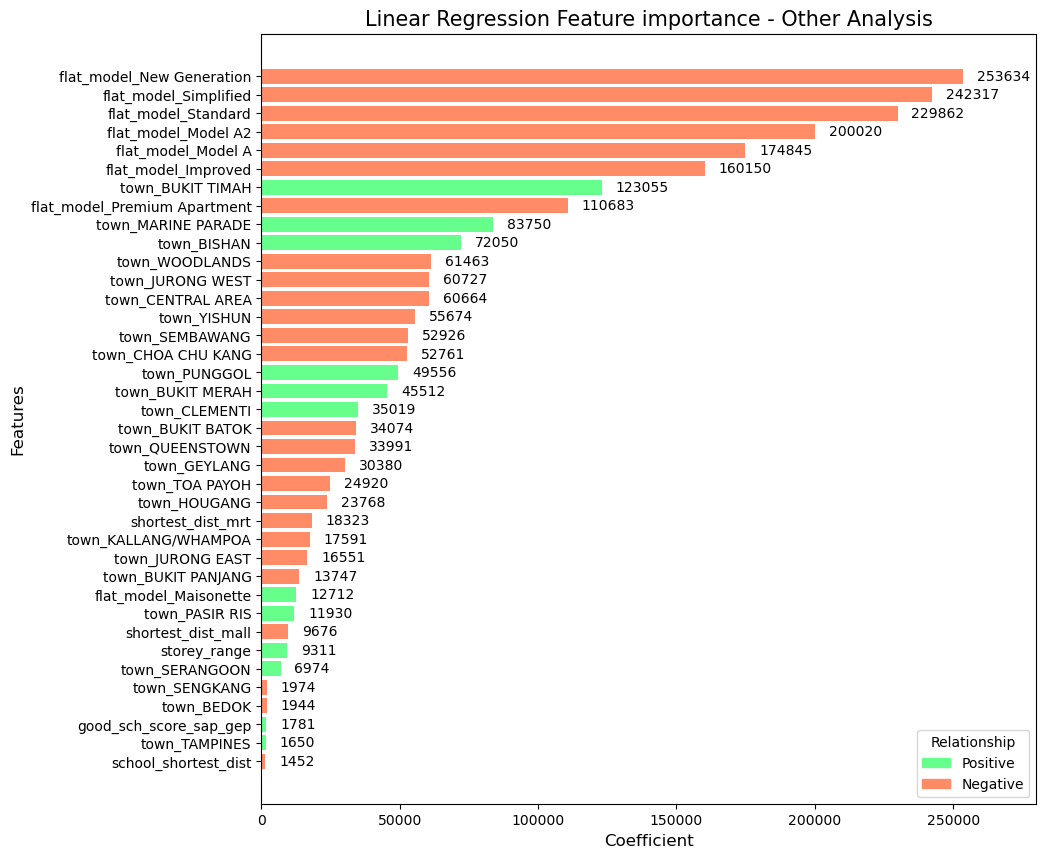

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
graph = ax.barh(lr3_importance['Features'], lr3_importance['Coeff_ABS'],
                color=lr3_importance['color'])


colors = {'Positive':'#66ff8c', 'Negative':'#ff8c66'}       
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, title='Relationship',loc='lower right', fontsize ='10')

plt.title('Linear Regression Feature importance - Other Analysis', size = 15)
plt.ylabel('Features', size = 12)
plt.xlabel('Coefficient', size = 12)
ax.bar_label(graph, fmt='%.0f', padding =10)
ax.set_xlim(right=280000) 
ax.invert_yaxis()

plt.show()

Running Default Parameter Random Forest

In [48]:
rf_3 = RandomForestRegressor(random_state = 100)
rf_3_r2, rf_3_mae, rf_3_rmse = model_performance(rf_3, X2_train, X2_test, y2_train, y2_test)

rf_3_importance = pd.DataFrame(list(zip(rf_3.feature_names_in_, rf_3.feature_importances_)), columns =['Features', 'Coeff'])
rf_3_importance = rf_3_importance.sort_values(by = 'Coeff', ascending = False).reset_index(drop =True)
rf_3_importance

R^2 score = 0.688883284120756
MAE: 55447.39218247277
RMSE 69639.00523903171


,Features,Coeff
0,storey_range,0.131002
1,shortest_dist_mrt,0.125549
2,shortest_dist_mall,0.119372
3,flat_model_New Generation,0.099772
4,school_shortest_dist,0.096560
5,flat_model_Maisonette,0.062988
6,flat_model_Simplified,0.029251
7,flat_model_Improved,0.029130
8,flat_model_Model A,0.026657
9,flat_model_Standard,0.025770


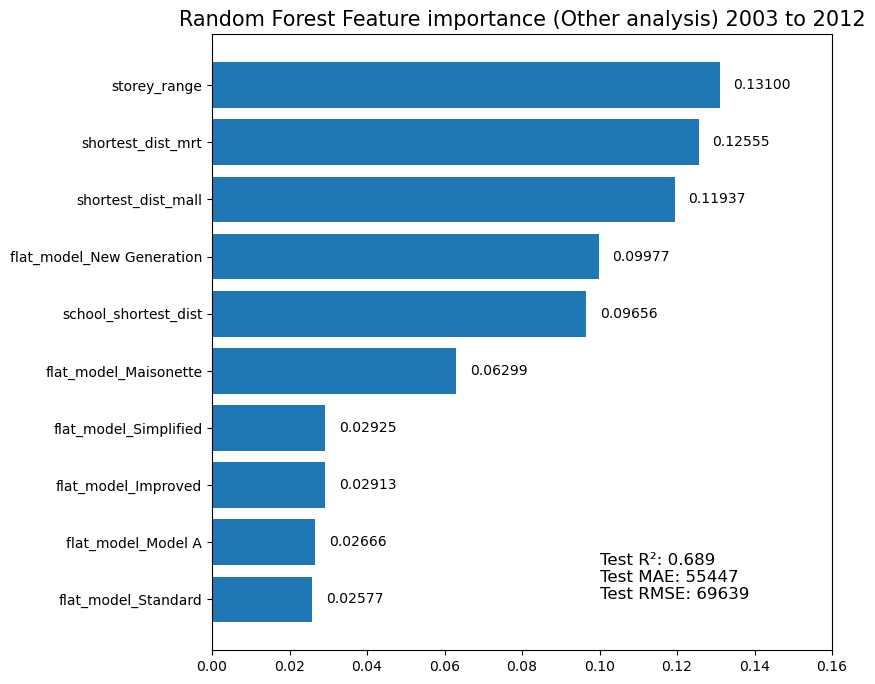

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
rf_3_importance_graph = rf_3_importance.head(10)
graph = ax.barh(rf_3_importance_graph['Features'], rf_3_importance_graph['Coeff'])
plt.title('Random Forest Feature importance (Other analysis) 2003 to 2012', size = 15)
plt.annotate(('Test R\u00b2: ' + str(round(rf_3_r2,3)) + '\nTest MAE: ' + str(round(rf_3_mae))+
             '\nTest RMSE: ' + str(round(rf_3_rmse))),
             xy=(0.1,9), fontsize = 12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.bar_label(graph, fmt='%.5f', padding =10)
ax.set_xlim(right=0.16) 
ax.invert_yaxis()


plt.show()

#### Computing SHAP values to determine directionality in features

In [31]:
import shap

In [32]:
model = RandomForestRegressor(random_state = 100)
model.fit(X_train, y_train)

shap.initjs()
explainer = shap.TreeExplainer(model)

Smallest Y Values

In [33]:
y_test = y_test.reset_index()

In [34]:
smallest = y_test['adjusted_price'].nsmallest(2).index

In [35]:
smallest_1 = smallest[0]
shap_values = explainer.shap_values(X_test.iloc[[smallest_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[smallest_1]])

In [36]:
smallest_2 = smallest[1]
shap_values = explainer.shap_values(X_test.iloc[[smallest_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[smallest_2]])

Median Y Values

In [37]:
temp = y_test['adjusted_price']

# get the median value of the Series
median = temp.quantile(0.5)

# set the range around the median to include the two values closest to it
range_low = median - 0.5 * (temp.max() - temp.min()) / len(temp)
range_high = median + 0.5 * (temp.max() - temp.min()) / len(temp)

# use boolean indexing to get the indexes of the values that fall within the range around the median
median_indexes = temp[(temp >= range_low) & (temp <= range_high)].index

In [38]:
median_1 = median_indexes[0]
shap_values = explainer.shap_values(X_test.iloc[[median_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[median_1]])

In [39]:
median_2 = median_indexes[1]
shap_values = explainer.shap_values(X_test.iloc[[median_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[median_2]])

Largest Y Values

In [40]:
largest = y_test['adjusted_price'].nlargest(2).index

In [41]:
largest_1 = largest[0]
shap_values = explainer.shap_values(X_test.iloc[[largest_1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[largest_1]])

In [42]:
largest_2 = largest[1]
shap_values = explainer.shap_values(X_test.iloc[[largest_2]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[largest_2]])

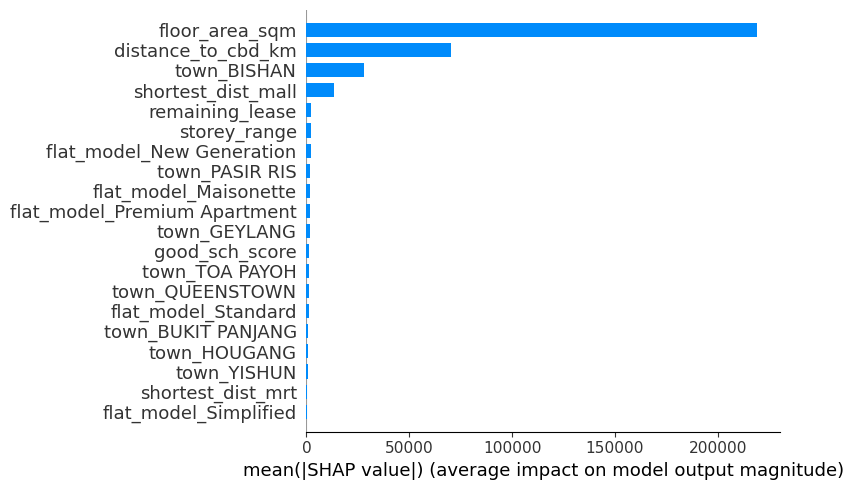

In [43]:
shap.summary_plot(shap_values, X_test, plot_type='bar',
                  plot_size = (8,5))